# Network utility functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil

import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt

from src.events.Events import (
    Events,
    write_npz,
)
from src.events.tools.generation.pix2nvs import Pix2Eve
from src.events.tools.generation.stimuli_gen import (
    moving_lines,
    disparity_bars
)
from src.events.tools.modification.event_modification import (
    rectify_events,
    concatenate_npz,
)
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
from src.spiking_network.network.network_params import (
    reinforcement_learning,
    inhibition_orientation,
    inhibition_disparity,
)
from src.spiking_network.network.neuvisys import (
    SpikingNetwork,
    delete_files,
    clean_network,
    shuffle_weights,
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    change_param,
    divide_visual_field,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

# network_path = home + "neuvisys-dv/configuration/network_ref_vh/"
network_path = home + "Desktop/Experiment/network_0/"

rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
disparities = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])

## CAUTION: Delete Weights

In [31]:
clean_network("/home/thomas/Desktop/Experiment/network_0/", [0, 1])

## Network creation and launch

In [5]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Experiment", 1)

In [11]:
launch_neuvisys_multi_pass("/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe",
                           "/home/thomas/Desktop/NET/network_experiment/configs/network_config.json",
                           "/home/thomas/Videos/lines/rotations/0.npz",
                           1)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 9141600 events...


CalledProcessError: Command '['/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe', '/home/thomas/Desktop/NET/network_experiment/configs/network_config.json', '/home/thomas/Videos/lines/rotations/0.npz', '1']' died with <Signals.SIGSEGV: 11>.

In [ ]:
# Launch training of multiple networks

n_networks = 100
exec_path = home + "neuvisys-dv/build/neuvisys-exe"
networks_path = home + "Desktop/test/"
event_path = home + "Desktop/shapes.npz"

params = {"simple_cell_config": {"TARGET_SPIKE_RATE": [0.1, 0.2, 0.3]}}

create_networks(exec_path, networks_path, n_networks, params)
nb_iterations = 5

df = []

for i in range(0, n_networks):
    launch_neuvisys_multi_pass(
        exec_path, networks_path + "network_" + str(i) + "/configs/network_config.json", event_path, nb_iterations,
    )

    spinet = SpikingNetwork(networks_path + "network_" + str(i) + "/")
    # display_network([spinet], 0)
    # update_dataframe(df, spinet)

# df = pd.DataFrame(df)
# df.to_csv(home + "Desktop/test/df")

#### Orientation response

In [ ]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
network_path = home + "Desktop/network_experiment/"
event_rotation = home + "Videos/lines/rotations/"

spikes = [[], []]
for rot in rotations:
    launch_neuvisys_multi_pass(exec_path, network_path + "configs/network_config.json",
                               event_rotation + str(rot) + ".npz", 5)
    spinet = SpikingNetwork(network_path)
    spikes[0].append(spinet.spikes[0])
    spikes[1].append(spinet.spikes[1])
spinet.save_complex_directions(spikes[1], rotations)

#### Disparity response

In [ ]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
network_path = home + "Desktop/network_experiment/"
event_disparity = home + "Videos/disparity/base_disp/"

spikes = [[], []]
for disp in disparities:
    launch_neuvisys_multi_pass(exec_path, network_path + "configs/network_config.json",
                               event_disparity + str(disp) + ".npz", 5)
    spinet = SpikingNetwork(network_path)
    spikes[0].append(spinet.spikes[0])
    spikes[1].append(spinet.spikes[1])
spinet.save_complex_disparities(spikes[1], disparities)

#### Inhibition weight learning

In [9]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
networks_path = home + "Desktop/Experiment/"
event_path = home + "Videos/disparity/"

# orientations
shapes = home + "Videos/shapes.npz"
# h_events = home + "Videos/lines/hlines.npz"
# v_events = home + "Videos/lines/vlines.npz"
# vh_events = home + "Videos/lines/vhlines.npz"
h_events = home + "Videos/lines/sim_h.npz"
v_events = home + "Videos/lines/sim_v.npz"
vh_events = home + "Videos/lines/sim_vh.npz"
rot_events = home + "Videos/lines/rotations.npz"
list_events_rot = [home + "Videos/lines/rotations/" + str(rotation) + ".npz" for rotation in rotations]

# disparity
events_0 = home + "Videos/disparity/disp_forward/0.npz"
list_disparities = [home + "Videos/disparity/disp_forward/" + str(disp) + ".npz" for disp in [0, 1, 2, 3, 4, 5]] + [
    home + "Videos/disparity/disp_backward/" + str(disp) + ".npz" for disp in [0, 1, 2, 3, 4, 5]]

In [14]:
create_networks(exec_path, networks_path, 1, inhibition_orientation())

##### learning the base network

In [11]:
## learning the base network
path = networks_path + "network_0/"

# disp = [list_disparities[index] for index in np.random.randint(0, 12, size=300)]
# for events in disp:
#     launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", events, 1)

launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", vh_events, 10)

Layer 0: new weights generated
Layer 1: new weights generated
Unpacking events...
Feeding network: 534970960 events...
0%
1%
1%
1%
1%
1%
4%
4%
5%
6%
6%
6%
6%
6%
6%
9%
9%
10%
10%
10%
12%
12%
12%
12%
12%
12%
14%
14%
14%
14%
15%
15%
15%
17%
17%
17%
17%
19%
19%
19%
19%
19%
19%
20%
20%
20%
22%
22%
22%
25%
25%
25%
26%
26%
26%
26%
26%
26%
28%
28%
28%
29%
31%
31%
31%
31%
31%
31%
31%
31%
33%
33%
33%
33%
33%
33%
35%
36%
36%
36%
39%
39%
39%
39%
39%
40%
40%
41%
41%
41%
41%
44%
44%
44%
44%
45%
45%
45%
47%
47%
47%
47%
49%
49%
49%
49%
49%
49%
49%
49%
49%
50%
50%
50%
50%
50%
50%
52%
52%
52%
55%
55%
55%
55%
55%
58%
58%
58%
58%
58%
59%
59%
60%
60%
60%
63%
63%
63%
63%
63%
65%
65%
65%
65%
65%
65%
66%
66%
66%
66%
66%
66%
66%
66%
66%
66%
68%
68%
68%
68%
68%
68%
68%
68%
70%
70%
71%
71%
71%
71%
71%
74%
74%
74%
74%
74%
75%
75%
76%
76%
76%
76%
76%
76%
76%
79%
79%
79%
80%
80%
80%
82%
82%
82%
82%
82%
84%
84%
84%
84%
84%
85%
85%
85%
85%
85%
85%
87%
87%
87%
87%
89%
89%
89%
89%
90%
90%
90%
90%
90%
90%
93%
93%
93%
93

##### learning inhibition weights

(array([37., 22.,  9.,  5.,  4.,  2.,  1.,  0.,  1.,  2.,  3.,  7., 17.,
        18.]),
 array([  1. ,  23.5,  46. ,  68.5,  91. , 113.5, 136. , 158.5, 181. ,
        203.5, 226. , 248.5, 271. , 293.5, 316. ]),
 <BarContainer object of 14 artists>)

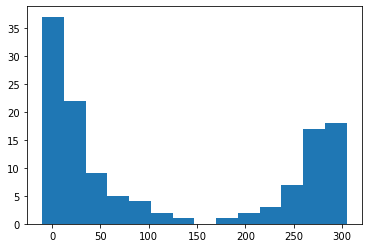

In [32]:
## learning inhibition weights
path = networks_path + "network_0/"

draw = np.round(laplace(0, 1.5).rvs(size=200)).astype(np.int64)
rotations_distribution = [list_events_rot[index] for index in draw if 16 > index > -17]

shutil.copytree(path, networks_path + "network_inhibition")
change_param(networks_path + "network_inhibition/configs/simple_cell_config.json", "STDP_LEARNING", "inhibitory")
change_param(networks_path + "network_inhibition/configs/complex_cell_config.json", "STDP_LEARNING", "none")

import re

distribution = ([int(re.findall('[0-9]+', string)[0]) for string in rotations_distribution])
plt.figure()
plt.hist(distribution, bins=np.arange(np.min(distribution) + 1, np.max(distribution) - 1, 22.5), align="left")

In [120]:
np.save(networks_path + "network_inhibition/distribution", draw)

In [34]:
# for eventfile in rotations_distribution:
#     launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", eventfile,
#                                1)

# for ind in draw:
#     launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", list_events_rot[int(ind)], 1)

for i in range(10):
    launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", v_events, 5)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 47866120 events...
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
356136
356271
356407
356543
356679
3

KeyboardInterrupt: 

In [ ]:
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_control")
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_experiment")

change_param(networks_path + "network_control/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_control/configs/complex_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/complex_cell_config.json", "STDP_LEARNING", "none")

##### experiment

In [ ]:
launch_neuvisys_multi_pass(exec_path, networks_path + "network_experiment/configs/network_config.json", vh_events, 2)

##### control test

In [ ]:
shuffle_weights(networks_path + "network_control/weights/0/")
launch_neuvisys_multi_pass(exec_path, networks_path + "network_control/configs/network_config.json", vh_events, 2)

## Event manipulation:
Functions for loading, writing or creating event files in the different formats (aedat4, npz, rosbag...)

In [39]:
# Load events
events = Events(home + "Videos/lines/sim_h.npz")

In [40]:
np.diff(events.events[:, 0])

array([ 92.,  92.,  92., ..., 111., 111., 111.])

In [29]:
# Concatenate events
list_events = ["/home/thomas/Videos/lines/sim_v.npz", "/home/thomas/Videos/lines/sim_h.npz"]
events_c = concatenate_npz(list_events)

In [30]:
# Save event file
events_c.save_file("/home/thomas/Videos/sim_vh")

In [41]:
# Merge left and right events
Events("/home/thomas/Videos/left.npz", "/home/thomas/Videos/right.npz").save_file("/home/thomas/Videos/disparity/test")

In [28]:
# Generate event video
events.to_video(10, "/home/thomas/Desktop/events", 346, 260)

279it [00:16, 17.14it/s]


In [ ]:
# Rectify events
rect_events = rectify_events((events[0].copy(), events[1].copy()), -5, -16, 5, 16)

In [8]:
list_events = []
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    list_events.append(np.load("/home/thomas/Videos/lines/rotations/" + str(rotation) + ".npz"))
events = concatenate_npz(list_events)

## Frame manipulation

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

In [ ]:
rect_frames = rectify_frames(frames, -4, 8, 4, -8)

write_frames(
    "/home/alphat/Desktop/im1/", rect_frames, ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
)

In [ ]:
# Stereo matching
disp_frames, disp_nb_frames = stereo_matching(
    "/home/alphat/Desktop/pavin_images/im1/", [10, 84, 158, 232], [20, 83, 146], range(0, 200),
)

## Create event videos

Generate frames of the desired visual stimuli, then convert those frames into an event stream

In [22]:
framerate = 1000
time_gap = 1e6 * 1 / framerate
pix2eve = Pix2Eve(
    time_gap=time_gap,
    log_threshold=0,
    map_threshold=0.4,
    n_max=5,
    adapt_thresh_coef_shift=0.05,
    timestamp_noise=50
)
folder = home + "Desktop/Events/right/"

In [ ]:
disparity_bars(folder, disparities=[0, 0, 0, 0], framerate=framerate)
disparity_bars(folder, disparities=[8, 6, 4, 2], framerate=framerate)

In [21]:
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    os.mkdir(folder + str(rotation) + "/")
    moving_lines(folder + str(rotation) + "/", time=2, rotation=rotation, framerate=framerate)

In [34]:
moving_lines(folder, time=2, framerate=framerate, rotation=0, disparity=0, frame_start=0)

In [20]:
print("Converting frames to event -> " + folder)

events = pix2eve.run("/home/thomas/Desktop/Events/left_f/")
events = events[events[:, 0].argsort()]
write_npz(home + "Videos/test", events)

Converting frames to event -> /home/thomas/Desktop/Events/right/
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion


In [27]:
folder = home + "Desktop/Events/"

moving_lines(folder + "left_f/", time=2, framerate=framerate, speed=-200, rotation=0, disparity=0, frame_start=0)
events = pix2eve.run(folder + "left_f/")
events = events[events[:, 0].argsort()]
write_npz(folder + "/left_e/0", events)

for i in range(-8, 9):
    moving_lines(folder + "right_f/", time=2, framerate=framerate, speed=-200, rotation=0, disparity=i, frame_start=0)
    events = pix2eve.run(folder + "right_f/")
    events = events[events[:, 0].argsort()]
    write_npz(folder + "/right_e/" + str(i), events)
    delete_files(folder + "right_f/")
    Events(folder + "left_e/0.npz", folder + "right_e/" + str(i) + ".npz").save_file(folder + str(i))

0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion
0.0%...
5.

## Divide visual field

In [122]:
print(divide_visual_field(3, 3, 40, 40))

([0.0, 153.0, 306.0], [0.0, 110.0, 220.0])
